In [1]:
import tensorflow as tf 
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [27]:
Image_size = 256
Batch_size = 8
Channels = 3
epochs= 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (Image_size, Image_size),
    batch_size = Batch_size
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
for image_batch, label_batch in dataset.take(1):
 
    print(image_batch.shape) # tensor 
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 1 1 2 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 0 1 1 1 1 0 1 1 1 0 1 2]


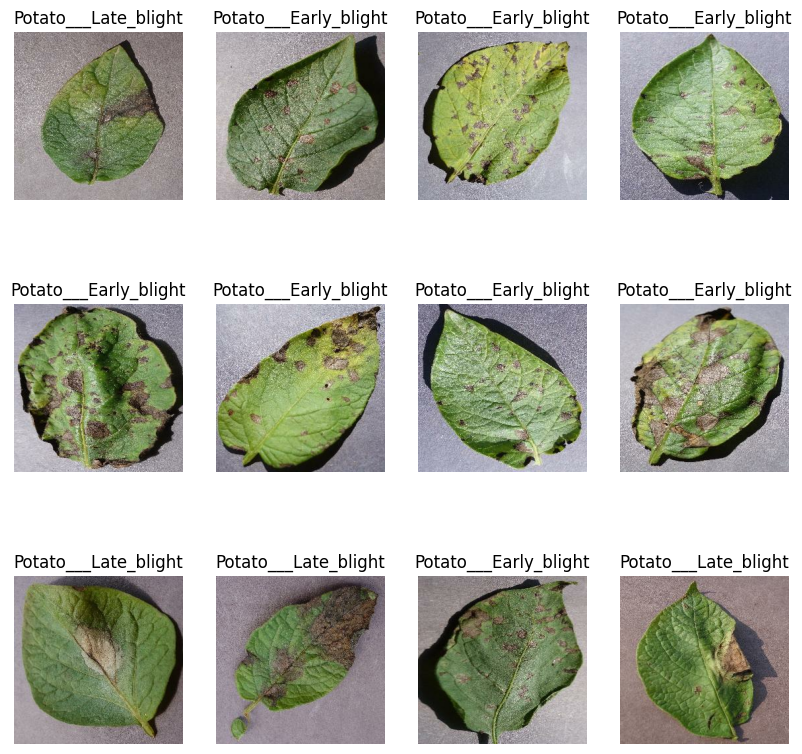

In [7]:
plt.figure(figsize=(10,10))

for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    
    

In [8]:
# 80% ==> training
# 20% ==> 10% validation, 10% test

In [9]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [10]:
train_ds = dataset.take(54)
len(train_ds)

54

In [11]:
test_ds = dataset.skip(54) 
len(test_ds)

14

In [12]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds= ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split* ds_size)
    val_size = int(val_split* ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

54

In [18]:
len(val_ds)

6

In [19]:
len(test_ds)

8

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_size, Image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [22]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [23]:
input_shape = (Batch_size, Image_size, Image_size, Channels)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'), 
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'), 
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'), 
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'), 
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation= 'softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    epochs=epochs,
    batch_size=Batch_size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 428s 8s/step - loss: 0.9211 - accuracy: 0.4948 - val_loss: 0.9162 - val_accuracy: 0.4531
Epoch 2/50
11/54 [=====>........................] - ETA: 5:04 - loss: 0.9148 - accuracy: 0.4574

KeyboardInterrupt: 

In [31]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 18s 2s/step - loss: 0.8628 - accuracy: 0.7227


In [32]:
scores

[0.8628227114677429, 0.72265625]